In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import KDTree
import numpy as np
import matplotlib.pyplot as plt



In [55]:
df = pd.read_csv('no_long_lat_nulls_2023.csv')

In [56]:
crime_locations = np.radians(df[['Latitude', 'Longitude']])

tree = KDTree(crime_locations, leaf_size=30)


In [57]:

import pandas as pd
from sklearn.neighbors import KDTree
import numpy as np

def crime_count(latitude, longitude, radius_km):
    """
    Calculate the intensity of crimes near a given latitude and longitude within a specified radius
    using a pre-built KD-tree for efficient nearest neighbor search
    """
    # Convert latitude and longitude to radians
    lat_radians = np.radians(latitude)
    lon_radians = np.radians(longitude)

    # Convert radius from kilometers to radians, earth's radius is aproximately 6378.137 km
    radius_radians = radius_km / 6378.137

    # Query the pre-built KD-tree for points within the specified radius
    num_crimes = tree.query_radius([[lat_radians, lon_radians]], r=radius_radians, count_only=True)[0]

    return num_crimes

# Example usage:
latitude =   53.56871588655912
longitude =   -2.8783616437225104
radius_km = 1 

intensity = crime_count(latitude, longitude, radius_km)
print("Crime intensity within", radius_km, "km radius:", intensity)


Crime intensity within 1 km radius: 724


# Calculating crime count categories

I will use this plot in photoshop to decide on the boundaries of the boxes that i will use in generating longitude and latitude steps


In [58]:
plt.figure(figsize=(100, 100))
plt.scatter(df['Longitude'], df['Latitude'], s=10)

# Adjust precision of x and y-axis
plt.xticks(np.arange(-9, 3, step=0.03),fontsize=5)
plt.yticks(np.arange(49, 56, step=0.01),fontsize=5)
# plt.yticks([round(y, 2) for y in plt.yticks()[0]])

plt.show()

In [59]:
#each latitude degree = 111.32 km
latitude_degree_distance = 111.32
latitude_step = radius_km / latitude_degree_distance

bounding_boxes = [
    {'top_left': (-8.114, 55.245), 'bottom_right': (-5.431, 54.021)},
    {'top_left': (-5.71, 51.24), 'bottom_right': (1.41, 49.96)},
    {'top_left': (-3.72, 51.565), 'bottom_right': (0.89, 51.24 + latitude_step)},
    {'top_left': (-5.30, 53.429), 'bottom_right': (1.769, 51.565 + latitude_step)},
    {'top_left': (-3.615, 55.068), 'bottom_right': (0.14, 53.429 + latitude_step)},
    {'top_left': (-2.605, 55.795), 'bottom_right': (-1.47, 55.068 + latitude_step)},
    {'top_left':  (-6.35, 49.967), 'bottom_right': (-6.276, 49.8895)},
]

#each longitude degree = cos(latitude) × 111.32 kilometers
def calculate_longitude_step(box):
    
    latitude_midpoint =  (box['top_left'][1] + box['bottom_right'][1]) / 2

    distance_per_longitude_degree = cos(radians(latitude_midpoint)) * latitude_degree_distance
    
    longitude_step = radius_km / distance_per_longitude_degree

    return longitude_step


def generate_points_in_box(box):
    longitude_step = calculate_longitude_step(box)
    top_left = box['top_left']
    bottom_right = box['bottom_right']
    
    latitude_points = [top_left[1] - i * latitude_step for i in range(int((top_left[1] - bottom_right[1]) / latitude_step) + 1)]
    longitude_points = [top_left[0] + i * longitude_step for i in range(int((bottom_right[0] - top_left[0]) / longitude_step) + 1)]
    
    points = [(longitude, latitude) for latitude in latitude_points for longitude in longitude_points]
    return points
all_points = []

for box in bounding_boxes:
    box_points = generate_points_in_box(box)
    all_points.extend(box_points)

# Output the total number of points
print(f"Total number of points generated: {len(all_points)}")


Total number of points generated: 257093


In [60]:
import folium

# Create a base map
map = folium.Map(location=[54.5, -5.8], zoom_start=8)  # Use an average location to center the map

# Add points to the map, taking every 100th point beca
for i in range(0, len(all_points), 90):
    lon, lat = all_points[i]
    folium.CircleMarker(location=[lat, lon], radius=3, color='red', fill=True).add_to(map)
map.save('map.html')

I will now make a new dataframe with the points scattered along the united kingdom

In [61]:
df_points = pd.DataFrame(all_points, columns=['Longitude', 'Latitude'])
#adding the crime count column
df_points['Crime Count'] = df_points.apply(lambda row: crime_count(row['Latitude'], row['Longitude'], radius_km), axis=1)
df_points.describe()

Longitude       Latitude    Crime Count
count  257093.000000  257093.000000  257093.000000
mean       -2.322629      52.486801      43.951418
std         2.282053       1.553645     290.484946
min        -8.114000      49.895135       0.000000
25%        -3.799394      51.105253       0.000000
50%        -2.129977      52.413908       0.000000
75%        -0.548286      53.792398       3.000000
max         1.768543      55.795000   47498.000000

## Problem
We can see that the data is dominated number of crime is 0, which makes sense since most of the points are in places that have no habitats 

## Approach 1
I tried making the radius 10 km which made it a lot better, but that makes the algorithm less useful because a 10 km radius is a big area so we will not use that approach 

## Approach 2
We can remove any points where the crime counts is 0 since the likelyhood of 0 crimes happening in a whole year within 1 kilometer is almost impossible and it indicates not much people live in the area, this will make the data way more useful


In [62]:
df_points = df_points[df_points['Crime Count'] != 0]
df_points.describe()

Longitude      Latitude   Crime Count
count  85630.000000  85630.000000  85630.000000
mean      -1.854468     52.487722    131.958449
std        1.925804      1.250498    491.663622
min       -8.114000     49.895135      1.000000
25%       -2.830794     51.466186      3.000000
50%       -1.623285     52.342043      9.000000
75%       -0.474502     53.375101     54.000000
max        1.753786     55.795000  47498.000000

That is much better, let's test it using the longitude and latitude of a place in Devon and Cornwall since it is one of the safest places to live in the uk
https://www.homeviews.com/blog/top-10-safest-places-to-live-in-the-uk

In [63]:
crime_count(50.718312296776354, -3.489225451953556,1)

246

This number exceeds the 75th percentile which indicates high amount of crimes, that is innacurate because it is supposed to be one of the safest places, that means our data is still skewed to th right. That makes sense since crimes could happen in random roads and places where not that much people live

## Approach 3
My last solution that uses longitude and latitude is to eliminate all crime counts below 500 since that will better indicate that it is a living area, I will try a complete new approach that transforms the longitude and latitude LSOA codes first using the google maps api,and calculating number of crime per 1000 people instead of within 1 km radius this other solution will be explained later

In [64]:
df_points = df_points[df_points['Crime Count'] > 250]
df_points.describe()

Longitude      Latitude   Crime Count
count  10241.000000  10241.000000  10241.000000
mean      -1.390799     52.453452    906.582658
std        1.352391      1.169437   1150.466431
min       -7.648402     50.099145    251.000000
25%       -2.127272     51.502118    378.000000
50%       -1.374671     52.333060    590.000000
75%       -0.321366     53.402051   1014.000000
max        1.753786     55.777034  47498.000000

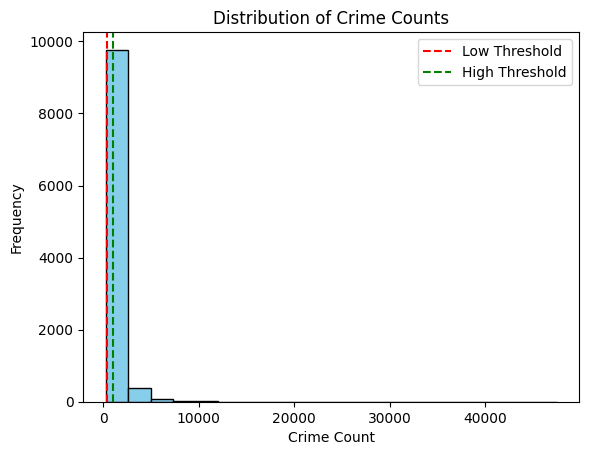

In [65]:
import pandas as pd

# Assuming you have a DataFrame named 'crime_data' containing crime counts

# Step 1: Compute summary statistics
crime_counts_summary = df_points['Crime Count'].describe()

# Step 2: Divide into categories (e.g., quartiles)
low_threshold = df_points['Crime Count'].quantile(0.25)
high_threshold = df_points['Crime Count'].quantile(0.75)

# Step 3: Define thresholds
low_threshold, high_threshold = crime_counts_summary['25%'], crime_counts_summary['75%']

# Step 4: Visualize the distribution (optional)
import matplotlib.pyplot as plt
plt.hist(df_points['Crime Count'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Crime Count')
plt.ylabel('Frequency')
plt.title('Distribution of Crime Counts')
plt.axvline(x=low_threshold, color='red', linestyle='--', label='Low Threshold')
plt.axvline(x=high_threshold, color='green', linestyle='--', label='High Threshold')
plt.legend()
plt.show()


In [68]:
quantiles = df_points['Crime Count'].quantile([0.20, 0.40, 0.60, 0.80]).tolist()

print("Crime Rate Thresholds:")
print(f"Very Low Crime: <= {quantiles[0]}")
print(f"Low Crime: > {quantiles[0]} and <= {quantiles[1]}")
print(f"Moderate Crime: > {quantiles[1]} and <= {quantiles[2]}")
print(f"High Crime: > {quantiles[2]} and <= {quantiles[3]}")
print(f"Very High Crime: > {quantiles[3]}")

Crime Rate Thresholds:
Very Low Crime: <= 348.0
Low Crime: > 348.0 and <= 489.0
Moderate Crime: > 489.0 and <= 724.0
High Crime: > 724.0 and <= 1167.0
Very High Crime: > 1167.0
